# Notebook content Overview

This notebook presents routines that allow to understand whether a functionally matched neuron is orientationn selective, orientation and direction selective or none of the two. It also allows to estimated the angle of the preferred orientation of the neuoron

### Data Read In

This notebook uses the data **clean_functional_ccmax_ost.pkl** extracted in the *neuron_activity_extraction.ipynb* notebook.

### Utility functions

Defined functions to extract the activity of neurons at differennt angle orientations in Monet2 trials, to fit and test different functions that would describe the selectivity porfile of the neuron to different orientationns present in said trials.

### Running code on a single neuron

This section contains code to understandn whether a single neuron is orientation selective, orientation and direction selective or none of the two.

### Run the routine on the functionally matched cells

This section contains a routine to estimate the preferred orientation of neurons that are funnctinally matched and to save a set of variables to understand if said neurons are orientationn selective, orientation and direction selective or none of the two.

    NOTE: each session and scan_idx was saved locally separately in a file labelled according to the following schema **orientations_fits_{session}_{scan_idx}.csv**. All teh files where then loaded and merged in to a singel one labelled **orientation_fits.csv**

### Visualisations

This sections contain different visualisations to better understand the porportion of cells that fall in the different categories of selectivity


# Imports

In [1]:
import random
import datajoint as dj
from phase3 import nda, func, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
from PIL import Image
from matplotlib import cm
from collections import defaultdict
from scipy.optimize import curve_fit
import time
import gc
from PIL import Image
import warnings
import pickle
!pip3 install scikit-learn
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import r2_score
from scipy.stats import sem
from scipy.stats import mannwhitneyu, wilcoxon
import os

Connecting microns@db.datajoint.com:3306
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 60.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


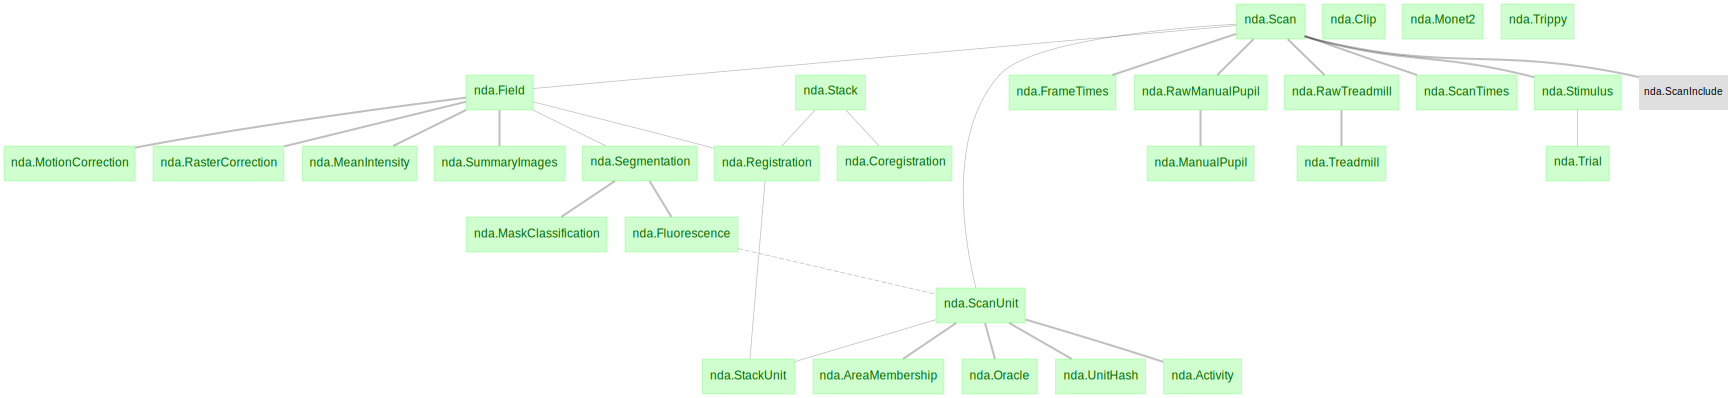

In [2]:
dj.ERD(nda)

# Data Read In

In [2]:
func_ccmax = pd.read_pickle('../analysis_v2/Data/clean_functional_neurons.pkl')

In [3]:
func_ccmax.head(5)

,pt_root_id,session,scan_idx,unit_id,cortex_layer,brain_area
0,864691136136642173,4,7,665,L1,RL
1,864691136208993724,4,7,740,L1,V1
2,864691135683934135,4,7,782,L1,V1
3,864691135334528233,4,7,855,L1,V1
4,864691136309730650,4,7,921,L1,RL


# Utility functions

In [3]:
def orientation_extractor(unit_key, fpd):
    ''' This function allows to extract the mean activity corresponding to each repeat
    of the direction shown as part of the Monet2 stimuli for a specified neuron

    Parameters:
    unit_key: dictionary specifying the value for the session, scan_idx and unit_idx keys
    fpd: frames per direction of the movie shown (might change in different session, scan_idx pairs)
    
    Returns:
    df: DataFrame with a columnd showing the directions inn degrees, teh directionns in radians and the
    mean activity of that cell across all the Monet2 trial that had that direction
    '''
    
    #Select the movie trials in the appropiate session and scan
    trial_key = {'session': unit_key['session'], 'scan_idx': unit_key['scan_idx']}
    trial_info = nda.Trial & trial_key
    
    #Extract the direction variables for the Monet2 stimuli in these trials
    dirs = (trial_info* nda.Monet2).fetch('directions')
    spike_trace = (nda.Activity() & unit_key).fetch1('trace')

    #Extract start and end frames
    s = (trial_info * nda.Monet2).fetch('start_idx')
    e = (trial_info * nda.Monet2).fetch('end_idx')
    
    #Loop thorugh them and calculate average activity and corresponding direction
    directions=[]
    m_act = []
    trial_id = []
    d = 0

    #loop though each monet trial
    for seg in range(len(s)):
        st = s[seg]
        en = e[seg]
        c = 0

        #extract the relevant spike trace segment
        sp_red = spike_trace[st:en+1]
        #loop though each six frames with same orientation
        if fpd>6: #change number of frame that have the same direction since session 9 had a higher frame rate of 8
            for i in range(0, sp_red.shape[0], fpd):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+fpd])) #append mean activity to frames with same orientation
                else:
                    continue
                    #directions.append(dirs[d][0][c])
                    #m_act.append(np.mean(sp_red[i:]))
                c+=1
                trial_id.append(d)
        else:    
            for i in range(0, sp_red.shape[0], 6):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+6])) #append mean activity to frames with same orientation
                else:
                    directions.append(dirs[d][0][c])
                    m_act.append(np.mean(sp_red[i:]))
                c+=1
                trial_id.append(d)
        d+=1
    #Save them in a data frame  
    df = pd.DataFrame({'orientation':directions, 'mean_activity':m_act, 'trial_id':trial_id})
    
    #Turn orientation in to radians
    df['radians'] = df['orientation']*(np.pi/180)
    
    return df

In [4]:
def von_mises(theta, A, phi, k):
    '''Function describing the tuning curve of the neurone to the orientation of the stimulus if the neurone is ONLY
    orientation selective
    
    Parameters:
    theta: orientation of the stimulus
    A: amplitude of the cosine wave
    phi: offset of the wave
    rmax: maximum value the activation can take (max value of sigmoid function)
    L0: inflection point of the sigmoid
    
    Returns:
    activity of neuron at specified angle'''
    
    r = A*np.exp(k*(np.cos(2*(theta-phi))-1))
    
    return r

In [5]:
def von_mises_single(theta, A, phi, k):
    ''' Function describing the tuning curve of the neurone to the orientation of the stimulus if the neuron
    is both orientation and direction selective
    
    Parameters:
    theta: orientation of the stimulus
    A: amplitude of the cosine wave
    phi: offset of the wave
    rmax: maximum value the activation can take (max value of sigmoid function)
    L0: inflection point of the sigmoid
    
    Returns:
    activity of neuron at specified angle'''
    
    r = A*np.exp(k*(np.cos((theta-phi))-1))
    
    return r

In [6]:
def is_selective(df, max_rad, single = True):
    '''This function utilises a wilcoxon test to understand if there is a significant difference
    between the activity of a neuron at its estimated preferred orientation and its estimated least preferred
    orientation so as to understand if its oreintation and direction selective or just orientation
    
    Parameters:
    df: DataFrame with directions and mean activity at each direction
    max_rad: integer or float with estimated preferred orientation of the cell
    single: boolean idenfiying whether we are testing for oreintationn selectivity (single = True)
    or orientation and direction selectivity (single = False)
    
    Returns:
    statw: wilcoxon statistics value
    pw: p value of the wilcoxon test
    min_rad: estimated least preferred orientation
    '''
    #If there is a single peak, frequency of 2pi
    if single:
        if max_rad>np.pi:
            min_rad = max_rad-np.pi
        else:
            min_rad = max_rad+np.pi
    
    #If there are two peaks, frequency of pi
    else:
        if max_rad>(np.pi*1.5):
            min_rad = max_rad-(np.pi/2)
        else:
            min_rad = max_rad+(np.pi/2)
        
    
    closemax= df.iloc[(df['radians']-max_rad).abs().argsort()[:1]].iloc[0,3]
    closemin = df.iloc[(df['radians']-min_rad).abs().argsort()[:1]].iloc[0,3]
    max_act = df[df['radians'] == closemax]['mean_activity']
    min_act = df[df['radians'] == closemin]['mean_activity']
    statw, pw = wilcoxon(max_act, min_act)
    
    return statw, pw, min_rad

In [7]:
def constrainer(dirs):
    '''Function that constrains given matrix of directions between [-2pi, 2pi] in to (-pi, pi]
    Parameters:
    dirs: numpy array of directions
    
    Returns:
    all_truncated:numpy array of constrained directions
    '''
    

    #remap between [-np.pi, np.pi]
    #find cells below -np.pi
    smaller = (dirs<=-np.pi).astype(int)*(2*np.pi)
    
    #find cells above np.pi
    larger = (dirs>np.pi).astype(int)*(2*np.pi)

    #add 2pi to dirs below -np.pi
    small_truncated = dirs+smaller

    #subtract 2pi to cells above np.pi
    all_truncated = small_truncated-larger

    return all_truncated

# Running code on a single neuron

## Extract orientations and activity

In [8]:
pairs = {(4, 7), (5, 3), (5, 6),(5, 7),(6, 2),(6, 4),(6, 6),(6, 7),(7, 3),(7, 4),(7, 5),(8, 5),(9, 3),(9, 4),(9, 6)}

In [9]:
directions = []
for i in tqdm(pairs):
    if i[0] == 9:
        continue
    trial_key = {'session': i[0], 'scan_idx': i[1]}
    trial_info = nda.Trial & trial_key
    tid = (trial_info * nda.Monet2).fetch('trial_idx')[0]
    u_key = {'session': i[0], 'scan_idx':i[1], 'trial_idx':tid}

    u_info = nda.Trial & u_key
    dirs = (u_info*nda.Monet2).fetch1('directions')[0]
    directions.append(sorted(list(dirs)))

a = np.array(directions)-np.array(directions)[0, :]
print(f'All sessions and scan with the same directions: {a[a>0].all()}')

  0%|          | 0/15 [00:00<?, ?it/s]

All sessions and scan with the same directions: True


NOTE:

Each of the Monet2 trials lasts 15 seconds displaying 95/96 frames with 16 different orinetation values.Each orientation value is displayed for 0.9375 seconds. There is a frame rate of 6.3 frames per second as per the nda.Scan() table.

This means that roughly there are 6.3 * 0.9375 =  5.90625 frames for each of the specific orientations

Ofcourse since we can't have 5.90625 of a frame I will thus take 6 frames per directions, leaving only five frames to the last directions when we have 95 total frames in the stimulus.

IN other sessions and scan (specifically (9,3), (9,4), (9,6)) a different fram rate (of 8 for the first two and 9 for the last) is used so the same reasoning is applied just with a different number of frames per directions after the rounding.

In [424]:
unit_key = {'session': 6, 'scan_idx': 2, 'unit_id': 4186} #3804,713                             
df = orientation_extractor(unit_key, 6)

NOTE

**Fringe cases**

1. If both models are significant and the double peak model has a difference in r squared greater than 0.8 than the single peak model then the neuron is actually not direction selective and the single peak (orientation+direction) model is mis-specified. A solution would be to save the difference and then accept the 'true maximum' as the one given by the  double peak model.

Example unit_id where this is the case:
(4,7) 937, 713, 7877, 6079, 8159| (8,5): 8083, 7809, 2538

2. If both models are significant but they have an r-squared difference lower than -0.5 that means the double model is mis-specified and we should accept the single peak model.

### Visualise tuning curve with inset

In [23]:
fits = pd.read_pickle('/workspaces/microns_phase3_nda/analysis_v2/Data/v1l234_neurons.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/microns_phase3_nda/analysis_v2/Data/v1l234_neurons.pkl'

In [ ]:
fits[fits['model_type']!='not_selective'].sort_values('osi', ascending = False).head(1)

,root_id,session,scan_idx,unit_id,model_type,phi,activity,orientations,cortex_layer,least_po,act_po,act_lpo,osi
1629,864691135986928643,5,6,5061,direction,1.570796,"[0.20456395, 0.19973853, 0.31263256, 0.1570677...","[0.0, 0.39269908169872414, 0.7853981633974483,...",L2/3,4.712389,0.660605,6.734930e-08,1.0


In [24]:
unit_key = {'session': 5, 'scan_idx': 6, 'unit_id': 5289} #3804,713                             
df = orientation_extractor(unit_key, 6)

In [25]:
#Calculating max activity for constraining von mises and standard errors, for plotting data and fit
gp = df.groupby('radians').mean().reset_index()
med = df.groupby('radians').median().reset_index()
s = df.groupby('radians').std().reset_index()
sem = df.groupby('radians')['mean_activity'].apply(lambda x: x.sem()).reset_index()
gp['std'] = s['mean_activity']
gp['sem'] = sem['mean_activity']
gp['med'] = med['mean_activity']
max_act_rad = gp.sort_values('mean_activity', ascending = False)['radians'].values[0]

#Using Von Mises
pars_d, pcov_d = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                       bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                       method = 'trf')

pars_s, pcov_s = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                       bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                       method = 'trf')


# Von Mises activities
ate_d= [von_mises(i,pars_d[0], max_act_rad, pars_d[1]) for i in gp['radians']]
ate_s= [von_mises_single(i,pars_s[0],  max_act_rad, pars_s[1]) for i in gp['radians']]

In [26]:

l23_n = fits[fits['cortex_layer'] == 'L2/3']
gp['radians_constr'] = constrainer(gp['radians'] )
gp = gp.sort_values('radians_constr')

NameError: name 'fits' is not defined

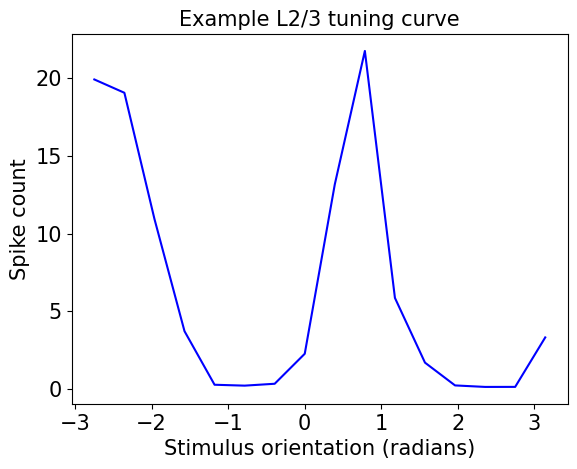

In [ ]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.64, 0.5, 0.25, 0.25]
# ax2 = fig.add_axes([left, bottom, width, height])


POid = np.argsort(gp['mean_activity'].values)[-1]
PO = gp['radians_constr'].values[POid]

ax1.plot(gp['radians_constr'],gp['mean_activity'], color = 'blue')
#ax1.axvline(PO, label = 'PO', color = 'purple')


# Add horizontal line and labels

ax1.set_ylabel('Spike count', fontsize = 15)
ax1.set_xlabel('Stimulus orientation (radians)', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.legend(loc = 'upper left')


# ax2.hist(l23_n[l23_n['model_type'] != 'not_selective']['osi'], 
#             color = 'blue', 
#             bins=np.linspace(0,1, 25),histtype = 'step', density = True)

# meanosil23 = np.mean(l23_n[l23_n['model_type'] != 'not_selective']['osi'])

# ax2.axvline(meanosil23,
#             color = 'red', label = 'Mean: '+ '%.2f' % round(meanosil23, 2))
# ax2.set_yticks([])
# ax2.set_xlabel('OSI')
# ax2.set_ylabel('Density')
# ax2.legend()


# ax2.set_title('OSI distribution (L2/3)', fontsize = 7)
ax1.set_title('Example L2/3 tuning curve', fontsize = 15)
plt.show()


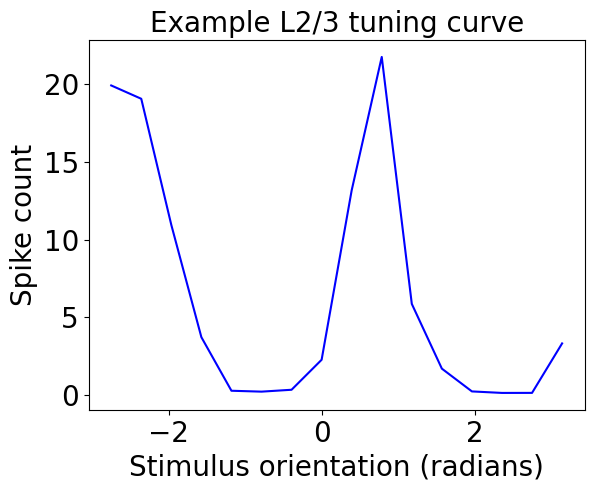

In [14]:

#fig, axis = axs.subplots()
fig, ax1 = plt.subplots()

POid = np.argsort(gp['mean_activity'].values)[-1]
PO = gp['radians_constr'].values[POid]

ax1.plot(gp['radians_constr'],gp['mean_activity'], color = 'blue')

ax1.set_ylabel('Spike count', fontsize = 20)
ax1.set_xlabel('Stimulus orientation (radians)', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_title('Example L2/3 tuning curve', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=20)

plt.show()

fig.set_size_inches(6, 5)  # Specify the width and height in inches
fig.savefig('tuning_curve.pdf', format='pdf', bbox_inches='tight')


## Fit the function to the data

In [56]:
# #Using Von Mises
# pars_d, pcov_d = curve_fit(von_mises, df['radians'], df['mean_activity'],
#                        bounds = ([-np.inf, 0, 0],[np.inf, 5.8904862254808625, np.inf]),
#                        method = 'trf')

# pars_s, pcov_s = curve_fit(von_mises_single, df['radians'], df['mean_activity'], 
#                        bounds = ([-np.inf, 0, 0],[np.inf, 5.8904862254808625, np.inf]),
#                        method = 'trf')

# #Calculating standard errors, for plotting data and fit
# gp = df.groupby('radians').mean().reset_index()
# med = df.groupby('radians').median().reset_index()
# s = df.groupby('radians').std().reset_index()
# sem = df.groupby('radians')['mean_activity'].apply(lambda x: x.sem()).reset_index()
# gp['std'] = s['mean_activity']
# gp['sem'] = sem['mean_activity']
# gp['med'] = med['mean_activity']

# # Von Mises activities
# ate_d= [von_mises(i,pars_d[0], pars_d[1], pars_d[2]) for i in gp['radians']]
# ate_s= [von_mises_single(i,pars_s[0],  pars_s[1], pars_s[2]) for i in gp['radians']]
#pars_d[1], pars_s[1]

In [57]:
# #Plot the real and estimated functons
# plt.errorbar(gp['radians'],gp['mean_activity'], gp['sem'], ecolor = 'black', marker = 'o', label = 'true activity')
# plt.plot(gp['radians'],ate_d, color = 'red', label = 'double')
# plt.plot(gp['radians'],ate_s, color = 'green', label = 'single')
# plt.axvline(np.pi, color = 'black', linestyle = '--')
# plt.axvline(np.pi/2, color = 'black', linestyle = '--')
# plt.axvline(3*np.pi/2, color = 'black', linestyle = '--')
# plt.axvline(2*np.pi, color = 'black', linestyle = '--')
# plt.axvline(pars_d[1], color = 'darkred', linestyle = '-', label = 'double peak max')
# plt.axvline(pars_s[1], color = 'lime', linestyle = '-', label = 'single peak max')
# plt.axvline(pars_s[1]-np.pi, color = 'darkolivegreen', linestyle = '-', label = 'single peak min')
# plt.axvline(pars_d[1]-(np.pi/2), color = 'gold', linestyle = '-', label = 'double peak min')


# #plt.plot(gp['radians'],gp['med'], color = 'gold', linestyle = '-')
# plt.legend()
# plt.show()

In [425]:
#Calculating max activity for constraining von mises and standard errors, for plotting data and fit
gp = df.groupby('radians').mean().reset_index()
med = df.groupby('radians').median().reset_index()
s = df.groupby('radians').std().reset_index()
sem = df.groupby('radians')['mean_activity'].apply(lambda x: x.sem()).reset_index()
gp['std'] = s['mean_activity']
gp['sem'] = sem['mean_activity']
gp['med'] = med['mean_activity']
max_act_rad = gp.sort_values('mean_activity', ascending = False)['radians'].values[0]

#Using Von Mises
pars_d, pcov_d = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                       bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                       method = 'trf')

pars_s, pcov_s = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                       bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                       method = 'trf')


# Von Mises activities
ate_d= [von_mises(i,pars_d[0], max_act_rad, pars_d[1]) for i in gp['radians']]
ate_s= [von_mises_single(i,pars_s[0],  max_act_rad, pars_s[1]) for i in gp['radians']]

In [426]:
pars_s

array([1.57128715, 0.27395358])

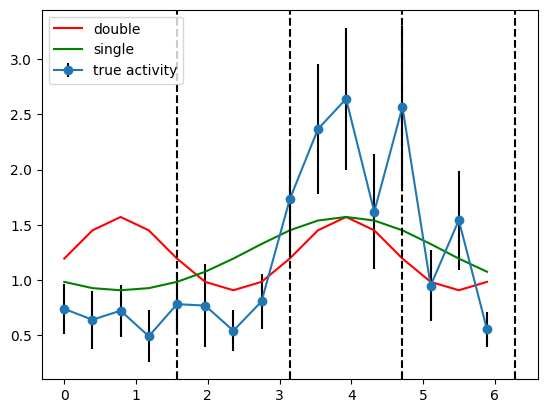

In [427]:
#Plot the real and estimated functons
#plt.axvline(max_act_rad, color = 'darkred', linestyle = '-', label = 'max')
#plt.axvline(max_act_rad+np.pi, color = 'darkolivegreen', linestyle = '-', label = 'single peak min')
#plt.axvline(max_act_rad+(np.pi/2), color = 'gold', linestyle = '-', label = 'double peak min')
plt.errorbar(gp['radians'],gp['mean_activity'], gp['sem'], ecolor = 'black', marker = 'o', label = 'true activity')
plt.plot(gp['radians'],ate_d, color = 'red', label = 'double')
plt.plot(gp['radians'],ate_s, color = 'green', label = 'single')
plt.axvline(np.pi, color = 'black', linestyle = '--')
plt.axvline(np.pi/2, color = 'black', linestyle = '--')
plt.axvline(3*np.pi/2, color = 'black', linestyle = '--')
plt.axvline(2*np.pi, color = 'black', linestyle = '--')
#plt.axvline(max_act_rad, color = 'darkred', linestyle = '-', label = 'max')
#plt.axvline(max_act_rad+np.pi, color = 'darkolivegreen', linestyle = '-', label = 'single peak min')
#plt.axvline(max_act_rad+(np.pi/2), color = 'gold', linestyle = '-', label = 'double peak min')


#plt.plot(gp['radians'],gp['med'], color = 'gold', linestyle = '-')
plt.legend()
plt.show()

In [225]:
rdouble = r2_score(gp['mean_activity'], ate_d)
rsingle = r2_score(gp['mean_activity'], ate_s)
rdouble, rsingle, rdouble-rsingle

(0.3970581313948669, 0.30962485619939706, 0.08743327519546984)

In [277]:
#Significance tests
#single
vs, ps, min_rads = is_selective(df, max_act_rad)
print(f'Single Peak W: stat_value: {vs}, p-value:{ps}')


#double
vdb, pdb, min_radd = is_selective(df, max_act_rad, single = False)
print(f'Double Peak W: stat_value: {vdb}, p-value:{pdb}')

Single Peak W: stat_value: 147.0, p-value:0.00023327588314714376
Double Peak W: stat_value: 102.0, p-value:9.59746103035286e-06


In [ ]:
pars_s[1], min_rads

# Run the routine on functionally matched cells

In [ ]:
#session and scan values for which we have cells
pairs = {(4, 7), (5, 3), (5, 6),(5, 7),(6, 2),(6, 4),(6, 6),(6, 7),(7, 3),(7, 4),(7, 5),(8, 5),(9, 3),(9, 4),(9, 6)}

In [ ]:
func_ccmax.groupby(['session', 'scan_idx']).count()

## Extracting selectivity information for the functionally matched cells

In [ ]:
#done:
# (9, 3), (9, 4), (9, 6)

In [43]:
datal234 = pd.read_csv('/workspaces/microns_phase3_nda/analysis_v2/Data/func_neuronsl234.csv')
datal234.head()

,pt_root_id,session,scan_idx,unit_id,cortex_layer
0,864691136521587601,4,7,2585,L2/3
1,864691135593561643,4,7,2591,L2/3
2,864691135382480602,4,7,2621,L2/3
3,864691135467558284,4,7,2626,L2/3
4,864691135683238898,4,7,2647,L2/3


In [65]:
for pair in [(9, 3), (9, 4)]:
    
    #Containers with saved data
    data = []
        
    #Von Mises
    columns = ['root_id', 'session', 'scan_idx','cell_id', 'pvalue','model_type', 
    'r_squared_diff', 'mean_r_sqrd', 'A', 'phi', 'k', 'activity', 'orientations']

    #Subset the cells for server limitation reasons
    sub = datal234[(datal234['session'] == pair[0]) & (datal234['scan_idx'] == pair[1])]
    
    #loop through cells
    for i in tqdm(range(sub.shape[0]), desc = 'cell loop' ):
        unit_key = {'session':sub.iloc[i, 1], 'scan_idx':sub.iloc[i, 2], 'unit_id':sub.iloc[i, 3]}

        df = orientation_extractor(unit_key, 8)


        #Calculating max activity for constraining von mises, for plotting data and fit
        gp = df.groupby('radians').mean().reset_index()
        max_act_rad = gp.sort_values('mean_activity', ascending = False)['radians'].values[0]
        
        #Using Von Mises
        pars_d, pcov_d = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                            bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                            method = 'trf')

        pars_s, pcov_s = curve_fit(lambda theta, A, k: von_mises(theta, A, max_act_rad, k), df['radians'], df['mean_activity'],
                            bounds = ([-np.inf, 0.1],[np.inf, np.inf]),
                            method = 'trf')



        # Von Mises activities
        ate_d= [von_mises(i,pars_d[0], max_act_rad,  pars_d[1]) for i in gp['radians']]
        ate_s= [von_mises_single(i,pars_s[0], max_act_rad,  pars_s[1]) for i in gp['radians']]
        
        r2d = r2_score(gp['mean_activity'], ate_d)
        r2s = r2_score(gp['mean_activity'], ate_s)

        #Calculate difference in r2 score between the two model fist to identify fringe cases
        rdiff = r2d-r2s
        
        #single
        vs, ps, max_rad = is_selective(df, max_act_rad)


        #double
        vdb, pdb, max_rad = is_selective(df, max_act_rad, single = False)
        
        
        #save data
        data.append([sub.iloc[i, 0], unit_key['session'], unit_key['scan_idx'], unit_key['unit_id'],ps,'single', rdiff, r2s, 
                     pars_d[0], max_act_rad,  pars_d[1], np.array(gp['mean_activity']), np.array(gp['radians'])])
        
        #save data
        data.append([sub.iloc[i, 0], unit_key['session'], unit_key['scan_idx'], unit_key['unit_id'],pdb,'double', rdiff,r2d, 
                     pars_s[0], max_act_rad,  pars_s[1], np.array(gp['mean_activity']), np.array(gp['radians'])])
        
    #Save the data
    data_df = pd.DataFrame(data, columns = columns)
    data_df.to_pickle(f'orientations_fits_{pair[0]}_{pair[1]}.pkl')
    
    #Clean RAM
    del sub, unit_key, df, gp, pars_s, pars_d, pcov_s, pcov_d, ate_d, ate_s, r2d, r2s, rdiff, vs, ps, vdb, pdb, max_rad
    gc.collect()    

cell loop:   0%|          | 0/570 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


IndexError: index 0 is out of bounds for axis 0 with size 0

In [31]:
df = orientation_extractor({'session':9, 'scan_idx':4, 'unit_id':5186}, 9)

In [32]:
df

,orientation,mean_activity,trial_id,radians


In [37]:
spike_trace = (nda.Activity() & {'session':9, 'scan_idx':4, 'unit_id':5186}).fetch1('trace')

In [42]:
spike_trace

array([6.0131789e-08, 9.7805327e-08, 1.6100562e-07, ..., 9.4700596e-08,
       1.0523639e-07, 5.6796004e-08], dtype=float32)

In [ ]:
#Joining all of the DataFrames
#Loading the first file in the directory
ors_all = pd.read_csv(f"../Data/orientation_fits/{os.listdir('../Data/orientation_fits')[0]}")

#Loading the rest iteratively and concatenating
for file in tqdm(os.listdir('../Data/orientation_fits')[1:]):
    if file!='.DS_Store':
        cont_df = pd.read_csv(f'../Data/orientation_fits/{file}')
        ors_all = pd.concat([ors_all, cont_df], axis = 0)
    else:
        continue

In [ ]:
#Saving the data
#ors_all.to_csv('orientation_fits.csv', index = False)

In [13]:
data_df = fs.copy()
data_df[data_df['r_squared_diff']<-0.7]


,session,scan_idx,cell_id,pvalue,model_type,r_squared_diff,mean_r_sqrd,A,phi,k
1944,5,3,5043,0.012896,single,-0.774522,7.748817e-01,2.454037,6.797259e-01,5.340069e-01
1945,5,3,5043,0.808824,double,-0.774522,3.598504e-04,1.557941,4.118102e+00,1.161626e-02
2816,5,7,4814,0.767453,single,-0.750838,7.849057e-01,8.950227,1.084741e+00,6.664477e-01
2817,5,7,4814,0.013903,double,-0.750838,3.406819e-02,5.823228,4.086769e+00,1.317982e-01
3136,5,7,8495,0.282239,single,-0.739628,8.134673e-01,1.328480,5.172686e+00,9.166228e-01
3137,5,7,8495,0.545273,double,-0.739628,7.383942e-02,0.821439,2.167722e+00,2.367949e-01
6352,5,6,4260,0.007477,single,-0.711820,7.469521e-01,7.915102,2.648396e-01,8.108303e-01
6353,5,6,4260,0.049713,double,-0.711820,3.513210e-02,4.891068,3.649274e+00,1.797506e-01
7872,6,2,4572,0.003692,single,-0.703905,7.421921e-01,2.806581,5.943106e+00,7.825902e-01
7873,6,2,4572,0.183292,double,-0.703905,3.828733e-02,1.758321,2.682405e+00,1.715878e-01


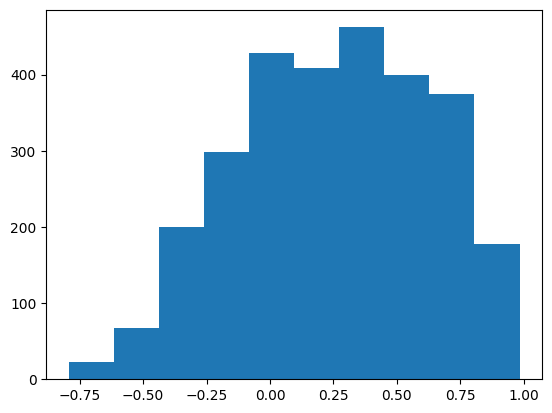

In [14]:
data_df[data_df['r_squared_diff']>0.01]
good = data_df[(data_df['pvalue']<0.05)]
grouped_res = good.groupby(['cell_id']).count().reset_index()
double_sig = grouped_res[grouped_res['pvalue']>1]['cell_id'].values
plt.hist(good[good['cell_id'].isin(double_sig)]['r_squared_diff'])#.sort_values('cell_id').tail(20)
plt.show()